In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import copy
import time


Population = 1e6
mu = 0.02
gamma = 0.09
R0Max=15                          # Upperbound of the transmissibility interval
N = 30                            # Discretization of the transmissibility interval [0,R0max]
Beta = np.zeros(N)
for i in range(0,N):
    Beta[i] = R0Max*gamma*i/(N-1) # Beta are chosen so the reproduction number R0=beta/gamma is in [0,R0max]
beta_init = 0.2                # Beta value of the initial straincy
M = 40                            # Discretizaton of the vaccine efficiency interval [0,1]
Omega = np.zeros(M)
for j in range(0,M):
    Omega[j] = j/(M-1)            # Omega is a discretization of [0,1]
sigma = 1
I_init = 200e-5
R_init = 0.25
C = 0.5                           
Xi = np.zeros((N,M,N,M))
for j in range (0,M):
    for l in range(0,M):
        value_to_assign = C*max(Omega[l]-Omega[j],0)/M 
        for i in range(0,N):
            for k in range(0,N):
                Xi[i,j,k,l] = value_to_assign
T = 350                # Final time
dt = .1                # Discretization step
NT = int(T/dt)         # Total number of steps
def etainf(t):
    # NPI has to be above this threshold (i.e. restrictions cannot be stronger)
    return 1
nusup = 0.006  # Maximum vaccination rate
lb = 0.1       # How fast do we update the control (lb is in [0,1])
counter_max = 1000
tol = 1e-3

def P_tensor ():
    return np.fromfunction(lambda i,j,k,l : 1/(2*np.pi*sigma**2)*np.exp(-((i-k)**2+(j-l)**2)/(2*sigma**2)), (N,M,N,M))

# Cut-off functions
def psi(x):
    #There is no point in considering values lower than 1/Population
    h = 1.0/Population

    if -h<x<h:
        return 0
    elif h<=x<2*h:
        return -3*x**3/h**2 + 14*x**2/h - 19*x + 8*h
    elif -2*h<x<=-h:
        return -3*x**3/h**2 - 14*x**2/h - 19*x - 8*h
    else:
        return x

def dpsi(x):
    # Cutoff function derivative
    h = 1.0/Population

    if -h<x<h :
        return 0
    elif h<=x<2*h:
        return -9*x**2/h**2 + 28*x/h - 19
    elif -2*h<x<=-h:
        return -9*x**2/h**2 - 28*x/h - 19
    else:
        return 1
   
def Psi(X):
    # Map Psi to a tensor no matter what it is
    return np.array([psi(e) for e in X.reshape(X.size)]).reshape(X.shape)
def Dpsi(X):
    # Map Psi_prime to a tensor no matter what it is
    return np.array([dpsi(e) for e in X.reshape(X.size)]).reshape(X.shape)

def plot_SIRVD(S_table,I_table,R_table,V_table,D_table,eta_table,nu_table,iteration):
    # Plots the values of S, I, R, V, D as well as eta
    # iteration is used in the filename of the image to indicate which iteration is being plotted
    
    print("Producing SIRVD plot at iteration %d"%iteration)
    
    t_table = np.arange(NT,dtype=float)
    I_00_table = np.arange(NT,dtype=float)
    R_00_table = np.arange(NT,dtype=float)

    for t in range(0,NT):

        t_table [t] = t*dt

        I = I_table[t]
        I_00_table[t] = np.sum(I)
        R = R_table[t]
        R_00_table[t] = np.sum(R) 

    plt.plot(t_table, S_table, color='b',label='S')
    plt.plot(t_table, eta_table, color='lightgray',label='eta')
    plt.plot(t_table, nu_table, color='gray',label='nu')
    plt.plot(t_table, I_00_table, color='r',label='I')
    plt.plot(t_table, R_00_table, color='g',label='R')
    plt.plot(t_table, D_table, color='k',label='D')
    plt.plot(t_table, V_table, color='m',label='V') 
    plt.plot(t_table, S_table + I_00_table + R_00_table + D_table + V_table, color='c',label='Total population')
    plt.xlabel('t')
    plt.ylabel('% population')
    plt.legend()
    plt.show()
        

def plot_adjoint(dHdnu_table,dHdeta_table,iteration):
    # Plots the values of dHdn and dHdeta
    # iteration is used in the filename of the image to indicate which iteration is being plotted
    
    print("Producing adjoint plot at iteration %d"%iteration)

    t_table = np.arange(NT,dtype=float)
    
    for t in range(0,NT):
        t_table [t] = t*dt

    # To better identify positive and negative values of dHdn and dHdeta, we will plot a line above or below
    # in salmon for dHdn and in beige for dHdeta
    dHd_max = max(dHdnu_table.max(),dHdeta_table.max())
    dHd_min = min(dHdnu_table.min(),dHdeta_table.min())
    if dHdnu_table.max()>dHdeta_table.max():
        precedence_nu = 1
        precedence_eta = 0.99
    else:
        precedence_nu = 0.99
        precedence_eta = 1
        
    plt.plot(t_table, dHdnu_table, color='r',label='Lambda_n')
    plt.plot(t_table, dHdeta_table, color='y',label='Lambda_eta')
    plt.plot(t_table, precedence_nu*((dHd_max+dHd_min)/2+(dHd_max-dHd_min)/2*np.sign(dHdnu_table)), color='mistyrose')
    plt.plot(t_table, precedence_eta*((dHd_max+dHd_min)/2+(dHd_max-dHd_min)/2*np.sign(dHdeta_table)), color='beige')
    plt.plot(t_table, np.zeros(NT), color='gray') 
    plt.xlabel('t')
    plt.legend()
    plt.show()


Producing SIRVD plot at iteration 1


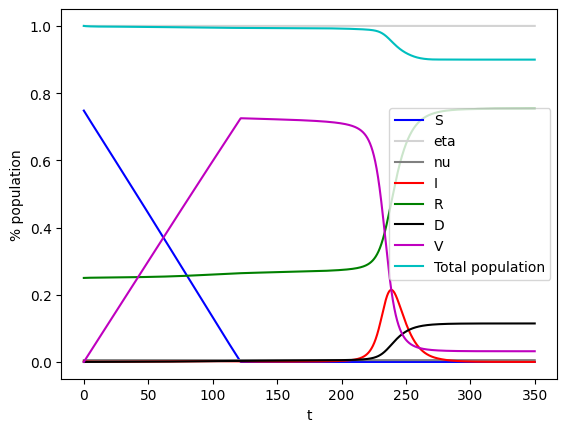

Producing adjoint plot at iteration 1


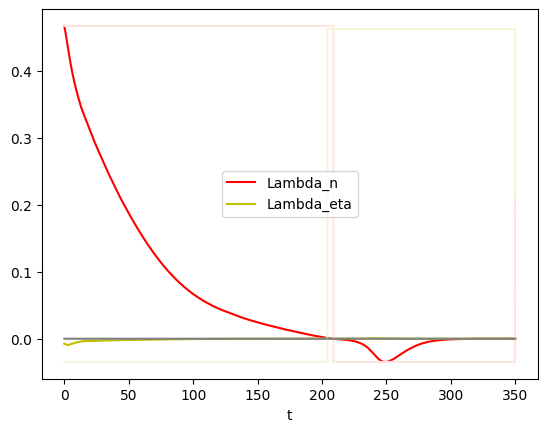

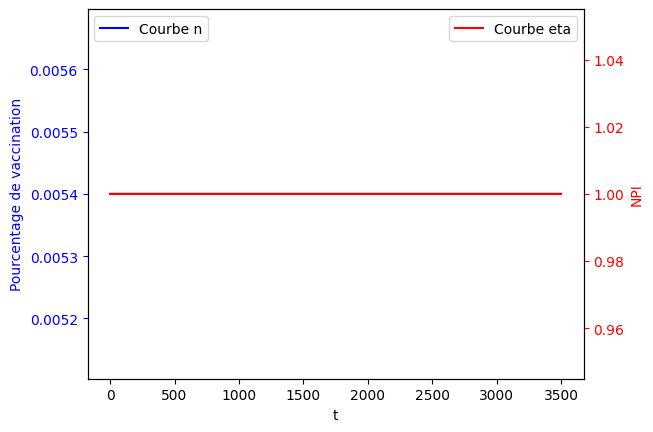

nu=1.890000e+01	eta=3.500000e+03	diff_nu=7.308000e-01	diff_eta=0.000000e+00	D=1.144869e-01
nu=1.701000e+01	eta=3.500000e+03	diff_nu=6.577200e-01	diff_eta=0.000000e+00	D=1.102358e-01
nu=1.532940e+01	eta=3.500000e+03	diff_nu=5.200080e-01	diff_eta=0.000000e+00	D=1.052644e-01
nu=1.383366e+01	eta=3.500000e+03	diff_nu=4.291104e-01	diff_eta=0.000000e+00	D=1.020116e-01


KeyboardInterrupt: 

In [4]:
start_time = time.time()

S_tab = np.zeros(NT,dtype=float)
V_tab = np.zeros(NT,dtype=float)
I_tab = np.zeros((NT,N,M),dtype=float)
R_tab = np.zeros((NT,N,M),dtype=float)
D_tab = np.zeros(NT,dtype=float)

pS_tab = np.zeros(NT,dtype=float)
pV_tab = np.zeros(NT,dtype=float)

dHdnu_tab  = np.zeros(NT,dtype=float)
dHdeta_tab = np.zeros(NT,dtype=float)

eta = np.zeros(NT,dtype=float)

for t in range(NT):
    eta[t] = etainf(t)

nu = nusup*np.ones(NT)

Beta_otimes_1 = np.outer(Beta,np.ones(M))
Beta_otimes_Omega = np.outer(Beta,Omega)

P3412 = np.transpose(P_tensor(),(2,3,0,1))
diff_nu=tol+1
diff_eta=tol+1
t_end_vaccination_campaign = NT

counter = 0

while abs(diff_nu)+abs(diff_eta)>tol and counter<=counter_max:

    # Initializations
    counter = counter + 1
    I = np.zeros((N,M))
    I[int(beta_init/gamma*(N-1)/R0Max),0] = I_init   # Initial strain has a transmission coefficient beta_init
    R = np.zeros((N,M))
    R[int(beta_init/gamma*(N-1)/R0Max),0] = R_init   # Initial strain has a transmission coefficient beta_init
    D = 0
    V = 0
    S = 1-V-D-np.sum(I)-np.sum(R)

    # Going forward
    
    for t in range(0,NT):

        S_tab [t] = copy.deepcopy(S)
        V_tab [t] = copy.deepcopy(V)
        I_tab [t] = copy.deepcopy(I)
        D_tab [t] = copy.deepcopy(D)
        R_tab [t] = copy.deepcopy(R)

        vac = min(nu[t],S*(1/dt-eta[t]*np.sum(I.transpose()@Beta)))

        if S<1/Population:
            t_end_vaccination_campaign = min(t,t_end_vaccination_campaign)

        S_prime = -vac - eta[t] * np.sum( I.transpose() @ Beta ) * S 
        V_prime =  vac - eta[t] * np.dot( I@Omega , Beta ) * V 
        I_prime = eta[t]*Beta_otimes_1*I*S + eta[t]*Beta_otimes_Omega*I*V - mu*I - gamma*I + eta[t]*np.tensordot(Xi,R,2)*I \
            + Psi(gaussian_filter(I,sigma,mode='constant',cval=0) - I)
        # P..I is achieved with gaussian_filter for efficiency purposes
        R_prime = gamma*I - eta[t]* np.tensordot(np.transpose(Xi,(2,3,0,1)),R,2) * I
        D_prime = mu*np.sum(I)

        S = S + dt * S_prime
        V = V + dt * V_prime
        I = I + dt * I_prime
        R = R + dt * R_prime
        D = D + dt * D_prime

    # Initializations
    
    pI = np.zeros((N,M))
    pR = np.zeros((N,M))
    pV = 0
    pS = 0

    old_nu = np.copy(nu)
    old_eta = np.copy(eta)

    # Going backwards
    
    for t in reversed(range(0,NT)):

        S = S_tab [t]
        V = V_tab [t]
        I = I_tab [t]
        R = R_tab [t]
        
        pS_tab [t] = pS
        pV_tab [t] = pV

        dHdnu  = pV-pS
        dHdeta = -pS*S*np.tensordot(Beta_otimes_1,I,2) \
            - pV*V*np.tensordot(Beta_otimes_Omega,I,2) \
            + np.tensordot(pI,Beta_otimes_1*I*S \
            +Beta_otimes_Omega*I*V+np.tensordot(Xi,R,2)*I,2) \
            - np.tensordot(pR,np.tensordot(np.transpose(Xi,(2,3,0,1)),I,2)*R,2)
        
        dHdnu_tab[t] = dHdnu
        dHdeta_tab[t] = dHdeta

        # Adapting nu and eta according the adjoint state
        
        if  dHdnu < 0 and S>0:
            nu[t] = (1-lb)*nu[t]+lb*nusup
        else:
            nu[t] = (1-lb)*nu[t]

        if dHdeta < 0:
            eta[t] = (1-lb)*eta[t]+lb
        else:
            eta[t] = (1-lb)*eta[t]+lb*etainf(t)

        # Going a step further (backwards)
        
        pS_prime = -eta[t]*np.tensordot(pI,Beta_otimes_1*I,2) \
            + eta[t]*pS*np.tensordot(Beta_otimes_1,I,2)
            
        pV_prime = -eta[t]*np.tensordot(pI,Beta_otimes_Omega*I,2) \
            + eta[t]*pV*np.tensordot(Beta_otimes_Omega,I,2)
            
        pI_prime = mu*(pI-np.ones((N,M))) + gamma*(pI-pR) \
            + eta[t]*(pS*Beta_otimes_1-pI*Beta_otimes_1)*S \
            + eta[t]*(pV*Beta_otimes_Omega-pI*Beta_otimes_Omega)*V \
            - np.tensordot(P3412,pI*Dpsi(gaussian_filter(I,sigma,mode='constant',cval=0)-I),2) \
            + pI*Dpsi(gaussian_filter(I,sigma,mode='constant',cval=0)-I) \
            - eta[t]*pI*np.tensordot(Xi,R,2) \
            + eta[t]*np.tensordot(np.transpose(Xi,(2,3,0,1)),R*pR,2)
            
        pR_prime = -eta[t]*np.tensordot(I*np.transpose(Xi,(2,3,0,1)),pI,2)\
            +eta[t]*np.tensordot(I,np.tensordot(Xi,pR,2),2)
        
        pS = pS - dt * pS_prime
        pV = pV - dt * pV_prime
        pI = pI - dt * pI_prime
        pR = pR - dt * pR_prime   
        
    if (counter-1)%5==0:
        plot_SIRVD(S_tab,I_tab,R_tab,V_tab,D_tab,eta,nu,counter)
        plot_adjoint(dHdnu_tab,dHdeta_tab,counter)
        
        fig, ax1 = plt.subplots()
        ax1.plot(nu, 'b-', label='Courbe n')
        ax1.set_xlabel('t')
        ax1.set_ylabel('Pourcentage de vaccination', color='b')
        ax1.tick_params('y', colors='b')
        ax2 = ax1.twinx()
        ax2.plot(eta, 'r-', label='Courbe eta')
        ax2.set_ylabel('NPI', color='r')
        ax2.tick_params('y', colors='r')
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')
        plt.show()
        
    diff_nu=abs(old_nu-nu)[0:t_end_vaccination_campaign].sum()
    diff_eta=abs(old_eta-eta).sum()
    
    print("nu=%e\teta=%e\tdiff_nu=%e\tdiff_eta=%e\tD=%e"%(abs(nu).sum(),abs(eta).sum(),diff_nu,diff_eta,D))